In [1]:
import pandas as pd
from pandas_ods_reader import read_ods
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = 'datasets/cool_temp_maize_soybean/'
file_names = ['flux_soc_out', 'atmosphere', 'n_out', 'n2o_nh3_out', 'p_out', 'soil_c_out', 'soil_water_out', 'surf_water_', 'temp_out']
start_year = 1998
growth_period = 6

In [3]:
def load_files(start_year: int, period: int, file_name : str, path: str, external_save: bool) -> pd.DataFrame:
    files = []
    for i in range(period + 1):
        
        if (start_year == 2001 and file_name == 'atmosphere_out'):
            start_year += 1
            continue
            
        df = read_ods(path + str(start_year) + file_name + '.ods')
        #some files have hourly data, so turn them into daily data
        if ('HOUR' in df.columns):
            df = df.drop(['DATE' , 'HOUR'], axis=1)
            df['DATE'] = pd.date_range(start='1/1/' + str(start_year), periods=len(df), freq='H')
            df.set_index('DATE', inplace=True)
            df = df.resample('D').mean().reset_index()
            
        #index used to make join faster 
        df.set_index('DATE')
        df = df.drop('DOY', axis=1)
        files.append(df)
        start_year += 1
    
    merged_data = pd.concat(files).reset_index().drop('index', axis=1)    
    if (external_save):
        abs_path = os.path.join(path, 'daily_data_merged/')
        if not os.path.exists(abs_path):
            os.makedirs(abs_path)
        merged_data.to_csv(os.path.join(abs_path, file_name + '.csv'))
    return merged_data

In [6]:
df = load_files(start_year, growth_period, file_names[0], path, False)

In [7]:
X, y = df.drop('CO2_FLUX', axis=1), df['CO2_FLUX']

In [8]:
X

,DATE,RESIDUE_C,HUMUS_C,AMENDED_C,LITTER_C,O2_FLUX,AUTO_RESP,MICRO_C,SURF_RES,CH4_FLUX,...,SOC_1,SOC_2,SOC_3,SOC_4,SOC_5,SOC_6,SOC_7,SOC_8,SOC_9,SOC_10
0,1011998.0,520.6404,5829.505,0.0,0.0,7.701474,0.0,173.56390,299.262200,-0.044962,...,208.3618,321.3799,978.3816,978.8501,959.8790,960.0927,347.6805,464.7213,394.9324,329.9658
1,2011998.0,520.2319,5827.954,0.0,0.0,17.841200,0.0,174.64740,298.954500,-0.057657,...,208.3715,321.2600,977.9357,978.4709,959.5856,959.8572,347.6099,464.6540,394.8999,329.9523
2,3011998.0,519.4646,5826.513,0.0,0.0,29.284860,0.0,175.87530,298.293300,-0.060575,...,208.4164,321.0845,977.5222,978.1268,959.3218,959.6431,347.5475,464.5858,394.8688,329.9361
3,4011998.0,518.7480,5825.145,0.0,0.0,40.257220,0.0,176.96220,297.681700,-0.060477,...,208.4474,320.9328,977.1290,977.7904,959.0721,959.4471,347.4888,464.5228,394.8343,329.9193
4,5011998.0,518.1078,5823.846,0.0,0.0,48.820270,0.0,177.89820,297.145300,-0.060302,...,208.4754,320.7908,976.7527,977.4705,958.8353,959.2623,347.4342,464.4627,394.7981,329.9024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,27122004.0,102.9864,5383.575,0.0,0.0,1047.704000,0.0,51.80003,6.953911,0.078235,...,224.7586,277.8950,904.1473,842.8201,817.0486,837.3776,319.5120,436.7137,382.7864,330.5983
2553,28122004.0,102.9408,5383.554,0.0,0.0,1048.570000,0.0,51.74522,6.946403,0.078249,...,224.7601,277.8897,904.1288,842.8070,817.0433,837.3719,319.5095,436.7107,382.7841,330.5938
2554,29122004.0,102.8962,5383.534,0.0,0.0,1049.527000,0.0,51.69143,6.939627,0.078262,...,224.7617,277.8842,904.1104,842.7940,817.0381,837.3661,319.5070,436.7078,382.7820,330.5895
2555,30122004.0,102.8534,5383.513,0.0,0.0,1050.430000,0.0,51.63892,6.933514,0.078276,...,224.7643,277.8791,904.0920,842.7811,817.0328,837.3604,319.5045,436.7048,382.7798,330.5852


In [9]:
y

0        -0.367903
1        -1.328162
2        -3.758204
3        -6.237416
4        -8.273404
           ...    
2552   -349.421500
2553   -349.432600
2554   -349.443500
2555   -349.454400
2556   -349.465400
Name: CO2_FLUX, Length: 2557, dtype: float64

In [10]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

In [11]:
train_y

1064   -138.331500
1116     -0.330760
512     -28.668990
1407   -295.114200
1580    -52.347190
           ...    
1147     -1.916404
2154   -422.275400
1766   -222.402600
1122     -0.442390
1346   -257.439500
Name: CO2_FLUX, Length: 1789, dtype: float64

In [12]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123, booster='gblinear')

In [13]:
  
# Fitting the model
xgb_r.fit(train_X, train_y)

[17:21:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [14]:
# Predict the model
pred = xgb_r.predict(test_X)
  

RMSE :  44.749799


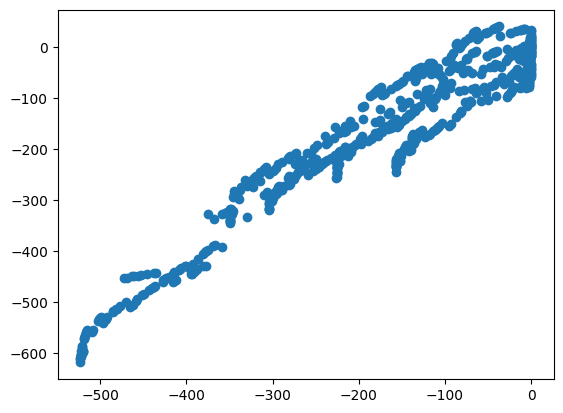

In [15]:
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
plt.scatter(test_y, pred)

In [16]:
xgb_r.coef_

array([-6.08278e-07,  1.27330e-01, -6.32132e-03,  0.00000e+00,
       -2.08242e-01, -7.35716e-02,  1.21305e+00,  5.83623e-01,
       -1.89737e-01,  1.01812e+01,  4.68281e+01, -3.26796e+02,
       -1.10461e+01,  4.37715e-03,  2.01390e-01,  0.00000e+00,
        6.81497e-01, -1.30673e-01,  1.32685e-01, -1.02729e-01,
       -3.51340e-02,  1.30319e-01, -2.50318e-01, -7.09967e-02,
        2.45925e-01, -4.20270e-01])

In [17]:
pd.DataFrame({'col_name': xgb_r.feature_importances_}, index=X.columns).sort_values(by='col_name', ascending=False)

,col_name
SUB_DOC_FLX,1.171309e+00
SUB_DIC_FLX,3.959183e-02
SOC_10,1.506342e-03
SOC_7,8.971966e-04
LITTER_C,7.463850e-04
SURF_RES,6.800590e-04
SOC_2,4.683602e-04
SOC_4,3.682041e-04
O2_FLUX,2.636975e-04
SOC_8,2.544684e-04
